## Importing libraries

In [86]:
import pip

try:
  import yfinance as yf
except ModuleNotFoundError:
  pip.main(['install', 'yfinance'])

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

## Fetching historical  data from Yahoo finance

In [87]:
ticker = "SBIN.NS" # @param {type:"string"}
stock_name = yf.Ticker(ticker).get_info()['shortName']

today = datetime.today()
past = (today - timedelta(days=365 * 10)) # 10 years ago

stock_data = yf.download(ticker, start=past.strftime("%Y-%m-%d"), end=today.strftime("%Y-%m-%d"))

pd.set_option("display.width", 100)

print('\n\n\n', stock_data)

close_prices = stock_data['Close'].values.reshape(-1, 1)


[*********************100%%**********************]  1 of 1 completed




                   Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2014-04-17  196.714996  202.199997  196.274994  201.729996  185.424545  21513800
2014-04-21  202.199997  207.880005  202.199997  207.210007  190.461624  18872420
2014-04-22  207.399994  207.699997  204.020004  204.854996  188.296951  18364100
2014-04-23  204.500000  207.800003  204.085007  206.520004  189.827393  23265390
2014-04-24  206.520004  206.520004  206.520004  206.520004  189.827393         0
...                ...         ...         ...         ...         ...       ...
2024-04-05  757.950012  767.700012  752.599976  764.750000  764.750000   9939620
2024-04-08  766.049988  770.000000  761.799988  768.299988  768.299988   9797174
2024-04-09  768.450012  772.450012  761.099976  764.200012  764.200012   7465892
2024-04-10  766.500000  780.700012  763.650024  779.049988  779.049988  14530669
2024-04-12  777.250000  

## Data Normalization

In [88]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

## Creating sequences

In [89]:
sequence_length = 50

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

## Split data into Train and Test sets

In [90]:
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Build the LSTM Model

In [91]:
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

## Train the LSTM model

In [92]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
68/68 [==============================] - 10s 77ms/step - loss: 0.0093
Epoch 2/50
68/68 [==============================] - 4s 63ms/step - loss: 0.0020
Epoch 3/50
68/68 [==============================] - 4s 64ms/step - loss: 0.0018
Epoch 4/50
68/68 [==============================] - 5s 78ms/step - loss: 0.0019
Epoch 5/50
68/68 [==============================] - 4s 62ms/step - loss: 0.0016
Epoch 6/50
68/68 [==============================] - 4s 66ms/step - loss: 0.0016
Epoch 7/50
68/68 [==============================] - 5s 73ms/step - loss: 0.0014
Epoch 8/50
68/68 [==============================] - 4s 62ms/step - loss: 0.0013
Epoch 9/50
68/68 [==============================] - 5s 75ms/step - loss: 0.0013
Epoch 10/50
68/68 [==============================] - 4s 63ms/step - loss: 0.0012
Epoch 11/50
68/68 [==============================] - 4s 62ms/step - loss: 0.0012
Epoch 12/50
68/68 [==============================] - 5s 77ms/step - loss: 0.0011
Epoch 13/50
68/68 [=================

## Use the last sequence from the training data to start predicting


In [93]:
current_sequence = X_train[-1]

## Predict future values

In [94]:
future_predictions_lstm = []
for i in range(365):  # Predicting for 1 year (365 days)
    pred = model_lstm.predict(current_sequence.reshape(1, sequence_length, 1))
    future_predictions_lstm.append(pred[0, 0])
    current_sequence = np.append(current_sequence[1:], pred[0])

1/1 [==============================] - 0s 25ms/step


## Unscale the LSTM predictions

In [95]:
future_predictions_lstm = scaler.inverse_transform(np.array(future_predictions_lstm).reshape(-1, 1))

## Build and compile the CNN model

In [96]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

## Train the CNN model

In [97]:
model_cnn.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
68/68 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 6.5937e-04
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 4.8744e-04
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 3.8765e-04
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 3.4152e-04
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 3.0773e-04
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 2.7849e-04
Epoch 8/50
68/68 [==============================] - 0s 3ms/step - loss: 2.2452e-04
Epoch 9/50
68/68 [==============================] - 0s 3ms/step - loss: 2.9016e-04
Epoch 10/50
68/68 [==============================] - 0s 4ms/step - loss: 2.1538e-04
Epoch 11/50
68/68 [==============================] - 0s 4ms/step - loss: 1.9804e-04
Epoch 12/50
68/68 [==============================] - 0s 3ms/step - loss: 1.9958e-04
Epoch

## Predict future values using CNN

In [98]:
future_predictions_cnn = []
for i in range(365):  # Predicting for 1 year (365 days)
    pred = model_cnn.predict(current_sequence.reshape(1, sequence_length, 1))
    future_predictions_cnn.append(pred[0, 0])
    current_sequence = np.append(current_sequence[1:], pred[0])

1/1 [==============================] - 0s 20ms/step


## Build and compile the FFNN model

In [99]:
model_ffnn = Sequential([
    Flatten(input_shape=(sequence_length, 1)),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])
model_ffnn.compile(optimizer='adam', loss='mean_squared_error')

## Train the FFNN model

In [100]:
model_ffnn.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
68/68 [==============================] - 1s 2ms/step - loss: 0.0071
Epoch 2/50
68/68 [==============================] - 0s 2ms/step - loss: 5.2129e-04
Epoch 3/50
68/68 [==============================] - 0s 2ms/step - loss: 4.3040e-04
Epoch 4/50
68/68 [==============================] - 0s 2ms/step - loss: 3.9573e-04
Epoch 5/50
68/68 [==============================] - 0s 2ms/step - loss: 3.7591e-04
Epoch 6/50
68/68 [==============================] - 0s 2ms/step - loss: 4.4898e-04
Epoch 7/50
68/68 [==============================] - 0s 2ms/step - loss: 3.4117e-04
Epoch 8/50
68/68 [==============================] - 0s 2ms/step - loss: 3.1134e-04
Epoch 9/50
68/68 [==============================] - 0s 2ms/step - loss: 3.5592e-04
Epoch 10/50
68/68 [==============================] - 0s 2ms/step - loss: 2.9077e-04
Epoch 11/50
68/68 [==============================] - 0s 2ms/step - loss: 2.9021e-04
Epoch 12/50
68/68 [==============================] - 0s 2ms/step - loss: 2.8693e-04
Epoch

## Predict future values using FFNN

In [101]:
future_predictions_ffnn = []
for i in range(365):  # Predicting for 1 year (365 days)
    pred = model_ffnn.predict(current_sequence.reshape(1, sequence_length, 1))
    future_predictions_ffnn.append(pred[0, 0])
    current_sequence = np.append(current_sequence[1:], pred[0])

1/1 [==============================] - 0s 23ms/step


## Unscale the FFNN predictions


In [102]:
future_predictions_ffnn = scaler.inverse_transform(np.array(future_predictions_ffnn).reshape(-1, 1))

## Unscale the CNN predictions

In [103]:
# Unscale the CNN predictions
future_predictions_cnn = scaler.inverse_transform(np.array(future_predictions_cnn).reshape(-1, 1))


## Calculate the standard deviation of daily returns in historical data

In [104]:
daily_returns = np.diff(stock_data['Close']) / stock_data['Close'][:-1]
volatility = np.std(daily_returns)

## Generate future predictions with added randomness for LSTM

In [105]:
future_predictions_lstm_with_noise = future_predictions_lstm.copy()
for i in range(len(future_predictions_lstm_with_noise)):
    noise = np.random.normal(loc=0, scale=volatility)
    future_predictions_lstm_with_noise[i] += noise

## Generate future predictions with added randomness for FFNN

In [106]:
future_predictions_ffnn_with_noise = future_predictions_ffnn.copy()
for i in range(len(future_predictions_ffnn_with_noise)):
    noise = np.random.normal(loc=0, scale=volatility)
    future_predictions_ffnn_with_noise[i] += noise

## Generate future predictions with added randomness for CNN

In [107]:
# Generate future predictions with added randomness for CNN
future_predictions_cnn_with_noise = future_predictions_cnn.copy()
for i in range(len(future_predictions_cnn_with_noise)):
    noise = np.random.normal(loc=0, scale=volatility)
    future_predictions_cnn_with_noise[i] += noise

## Generating future predictions with added randomness for AVERAGE

In [108]:
average_predictions = (np.array(future_predictions_lstm_with_noise) + np.array(future_predictions_ffnn_with_noise) + np.array(future_predictions_cnn_with_noise)) / 3

## Plot the results

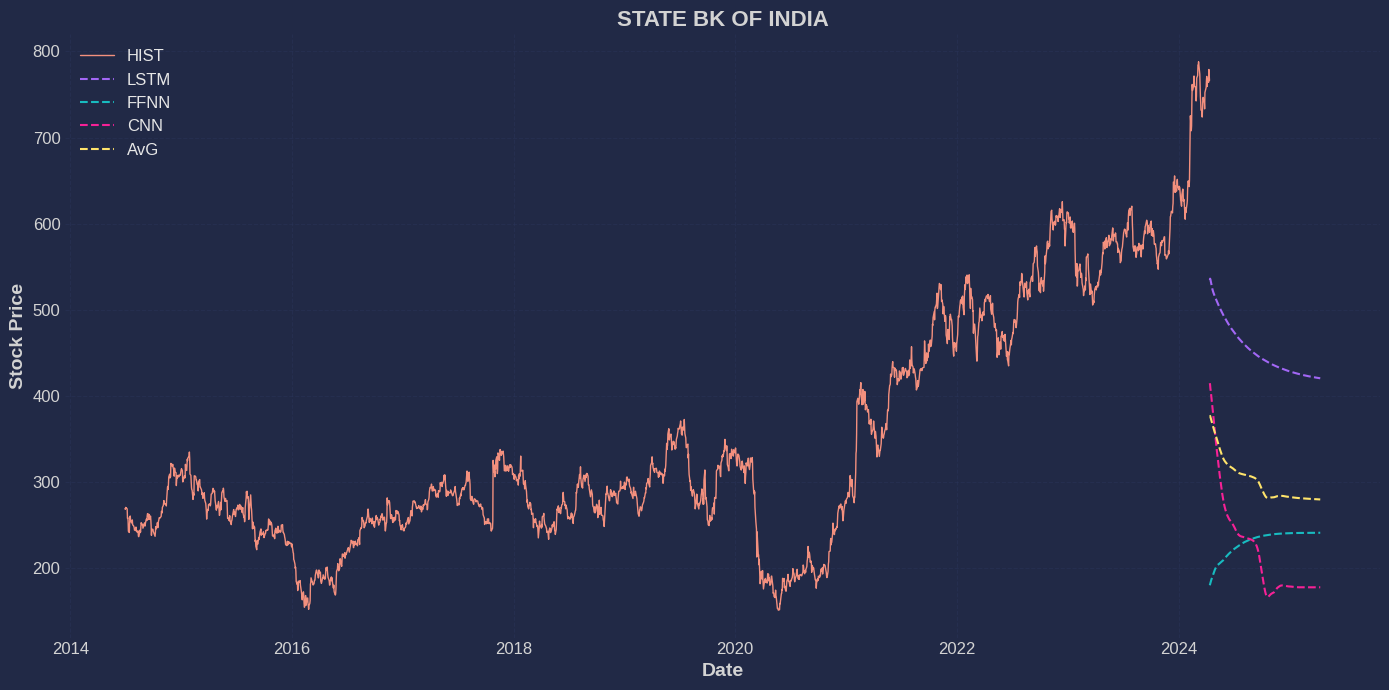

In [109]:
# Plot the results with dark theme and vibrant colors
plt.figure(figsize=(14, 7))
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

plt.plot(stock_data.index[-len(y):], scaler.inverse_transform(y), color='#F3907E', label='HIST', linewidth=1)

plt.plot(pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=365), future_predictions_lstm_with_noise, color='#A267F5', label='LSTM', linestyle='--')

plt.plot(pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=365), future_predictions_ffnn_with_noise, color='#18BBC0', label='FFNN', linestyle='--')

plt.plot(pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=365), future_predictions_cnn_with_noise, color='#F62196', label='CNN', linestyle='--')

plt.plot(pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=365), average_predictions, color='#FFE46B', label='AvG', linestyle='--')

plt.title(stock_name, fontsize=16, fontweight='bold', color='lightgray')
plt.xlabel('Date', fontsize=14, fontweight='bold', color='lightgrey')
plt.ylabel('Stock Price', fontsize=14, fontweight='bold', color='lightgrey')
plt.xticks(fontsize=12, color='lightgrey')
plt.yticks(fontsize=12, color='lightgrey')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()
